# Model details
***Used base model***: bert-base-uncased
***Used dataset***: SQuAD
***Batch size***: 4
***Early stopping patience***: 1
***Early stopping monitor***: val loss
***Attempted train epochs***: 10
***Initial learning rate***: 2e-5
***End learning rate***: 0
***Additional info***: Filtered out samples with number of tokens exceeding 384, stride mechanism isn't used

In [1]:
from transformers import (
    AutoTokenizer,
    TFAutoModelForQuestionAnswering,
    DefaultDataCollator,
)
import tensorflow as tf
from question_answering.constants import constants
from question_answering.utils import core_qa_utils, extractive_qa_utils
from question_answering.paths import extractive_qa_paths
import ipynbname
from question_answering.keras_callbacks.time_measure_callback import TimeMeasureCallback

# Data loading, analyzing and preprocessing

In [2]:
# Load SQuAD dataset
df_train, df_val, df_test = core_qa_utils.load_train_val_test_datasets(
    extractive_qa_paths.squad_dataset_dir
)

train_dataset, val_dataset, test_dataset = core_qa_utils.convert_dataframes_to_datasets(
    [df_train, df_val, df_test]
)

In [3]:
# Specify the base model and load its tokenizer
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [5]:
# Filter samples that are too long for model to handle
max_length = 384


def tokenize_sample(sample, max_tokens=None, padding=False):
    question = sample["question"].strip()
    context = sample["context"].strip()

    return tokenizer(question, context, max_length=max_tokens, padding=padding)


def filter_samples_below_number_of_tokens(dataset, max_tokens: int):
    indices_to_remove = []

    # Find indices of samples where number of tokens exceeds max number of tokens
    for index, sample in enumerate(dataset):
        tokenized_sample = tokenize_sample(sample)
        if len(tokenized_sample["input_ids"]) > max_tokens:
            indices_to_remove.append(index)

    # Keep only samples with number of tokens less or equal than max number of tokens
    dataset_indices = range(len(dataset))
    filtered_dataset = dataset.select(
        index for index in dataset_indices if index not in set(indices_to_remove)
    )

    return filtered_dataset


filtered_train_dataset = filter_samples_below_number_of_tokens(
    train_dataset, max_tokens=max_length
)
filtered_val_dataset = filter_samples_below_number_of_tokens(
    val_dataset, max_tokens=max_length
)
filtered_test_dataset = filter_samples_below_number_of_tokens(
    test_dataset, max_tokens=max_length
)

Parameter 'indices'=<generator object filter_samples_below_number_of_tokens.<locals>.<genexpr> at 0x000001E1E751ADC0> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [6]:
# Check how much samples were there before filtering too long samples and how much are there now
print(
    "Number of samples in tokenized train dataset before filtering: ",
    len(train_dataset),
)
print("Number of samples in tokenized val dataset before filtering: ", len(val_dataset))
print(
    "Number of samples in tokenized test dataset before filtering: ", len(test_dataset)
)

print("\n---------------\n")

print(
    "Number of samples in tokenized train dataset after filtering: ",
    len(filtered_train_dataset),
)
print(
    "Number of samples in tokenized val dataset after filtering: ",
    len(filtered_val_dataset),
)
print(
    "Number of samples in tokenized test dataset after filtering: ",
    len(filtered_test_dataset),
)

Number of samples in tokenized train dataset before filtering:  68716
Number of samples in tokenized val dataset before filtering:  14724
Number of samples in tokenized test dataset before filtering:  14725

---------------

Number of samples in tokenized train dataset after filtering:  67964
Number of samples in tokenized val dataset after filtering:  14573
Number of samples in tokenized test dataset after filtering:  14552


In [6]:
# Function for preprocessing the dataset
def preprocess_dataset(dataset):
    questions = [q.strip() for q in dataset["question"]]
    contexts = [c.strip() for c in dataset["context"]]

    inputs = tokenizer(
        questions,
        contexts,
        max_length=max_length,
        padding="max_length",
        return_offsets_mapping=True,
    )

    offset_mapping = inputs.pop("offset_mapping")

    answer_start_indices = dataset["answer_start"]
    answer_texts = dataset["answer_text"]
    start_positions = []
    end_positions = []

    for index, offset in enumerate(offset_mapping):
        start_char = answer_start_indices[index]
        end_char = start_char + len(answer_texts[index])
        sequence_ids = inputs.sequence_ids(index)

        # Find the start and end token indices of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [7]:
# Tokenize the dataset
tokenized_train_dataset = filtered_train_dataset.map(
    preprocess_dataset,
    batched=True,
    remove_columns=["index"],
)
tokenized_val_dataset = filtered_val_dataset.map(
    preprocess_dataset,
    batched=True,
    remove_columns=["index"],
)
tokenized_test_dataset = filtered_test_dataset.map(
    preprocess_dataset,
    batched=True,
    remove_columns=["index"],
)

Map:   0%|          | 0/67964 [00:00<?, ? examples/s]

Map:   0%|          | 0/14573 [00:00<?, ? examples/s]

Map:   0%|          | 0/14552 [00:00<?, ? examples/s]

In [9]:
# Check that all tokenized samples have max length of tokens
print(
    f"All tokenized train dataset entries have {max_length} tokens: ",
    all(
        [
            len(input_ids) == max_length
            for input_ids in tokenized_train_dataset["input_ids"]
        ]
    ),
)
print(
    f"All tokenized val dataset entries have {max_length} tokens: ",
    all(
        [
            len(input_ids) == max_length
            for input_ids in tokenized_val_dataset["input_ids"]
        ]
    ),
)
print(
    f"All tokenized test dataset entries have {max_length} tokens: ",
    all(
        [
            len(input_ids) == max_length
            for input_ids in tokenized_test_dataset["input_ids"]
        ]
    ),
)

All tokenized train dataset entries have 384 tokens:  True
All tokenized val dataset entries have 384 tokens:  True
All tokenized test dataset entries have 384 tokens:  True


In [8]:
# Model parameters
full_model_name = "-".join(ipynbname.name().split("_"))

# Checkpoints
checkpoint_filename_template = constants.checkpoint_filename_template
checkpoints_path = (
        extractive_qa_paths.training_checkpoints_dir
        / full_model_name
        / checkpoint_filename_template
)

# Saved models
saved_models_path = extractive_qa_paths.saved_models_dir / full_model_name

# Evaluation
model_evaluation_dir = extractive_qa_paths.model_evaluation_dir / full_model_name
figures_dir = model_evaluation_dir / constants.figures_dir_name

# Hyperparameters
batch_size = 4
train_epochs = 2
initial_learning_rate = 2e-5
end_learning_rate = 0

In [9]:
# Dataset preparation
data_collator = DefaultDataCollator(return_tensors="tf")

tf_train_dataset = core_qa_utils.convert_to_tf_dataset(
    hf_dataset=tokenized_train_dataset,
    columns=["input_ids", "token_type_ids", "attention_mask"],
    label_cols=["start_positions", "end_positions"],
    collator=data_collator,
    batch_size=batch_size,
)

tf_val_dataset = core_qa_utils.convert_to_tf_dataset(
    hf_dataset=tokenized_val_dataset,
    columns=["input_ids", "token_type_ids", "attention_mask"],
    label_cols=["start_positions", "end_positions"],
    collator=data_collator,
    batch_size=batch_size,
)

tf_test_dataset = core_qa_utils.convert_to_tf_dataset(
    hf_dataset=tokenized_test_dataset,
    columns=["input_ids", "token_type_ids", "attention_mask"],
    label_cols=["start_positions", "end_positions"],
    collator=data_collator,
    batch_size=batch_size,
)

# Model training

In [10]:
# Load model for fine-tuning
model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

All PyTorch model weights were used when initializing TFBertForQuestionAnswering.

Some weights or buffers of the TF 2.0 model TFBertForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    checkpoints_path, verbose=1, save_weights_only=True
)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=1)
time_measure_cb = TimeMeasureCallback()

callbacks = [
    checkpoint_cb,
    early_stop_cb,
    time_measure_cb
]

In [12]:
# Compile
num_train_steps = len(tf_train_dataset) * train_epochs

lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    end_learning_rate=end_learning_rate,
    decay_steps=num_train_steps,
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

# Train in mixed-precision float16
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# Compile
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Ti, compute capability 8.6


In [16]:
model.summary()

Model: "tf_bert_for_question_answering"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108891648 
                                                                 
 qa_outputs (Dense)          multiple                  1538      
                                                                 
Total params: 108,893,186
Trainable params: 108,893,186
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Fit the model on the new data
history = model.fit(
    tf_train_dataset,
    validation_data=tf_val_dataset,
    epochs=train_epochs,
    callbacks=callbacks,
)

Epoch 1/2
16991/16991 [==============================] - ETA: 0s - loss: 2.5295 - end_logits_loss: 1.2131 - start_logits_loss: 1.3164 - end_logits_accuracy: 0.6639 - start_logits_accuracy: 0.6248
Epoch 1: saving model to D:\dev\projects\question-answering\extractive-qa\training-checkpoints\squad-bert-uncased-2\cp-01.ckpt
16991/16991 [==============================] - 2757s 162ms/step - loss: 2.5295 - end_logits_loss: 1.2131 - start_logits_loss: 1.3164 - end_logits_accuracy: 0.6639 - start_logits_accuracy: 0.6248 - val_loss: 1.9327 - val_end_logits_loss: 0.9223 - val_start_logits_loss: 1.0104 - val_end_logits_accuracy: 0.7385 - val_start_logits_accuracy: 0.7042
Epoch 2/2
16991/16991 [==============================] - ETA: 0s - loss: 1.3938 - end_logits_loss: 0.6560 - start_logits_loss: 0.7378 - end_logits_accuracy: 0.8001 - start_logits_accuracy: 0.7614
Epoch 2: saving model to D:\dev\projects\question-answering\extractive-qa\training-checkpoints\squad-bert-uncased-2\cp-02.ckpt
16991/16

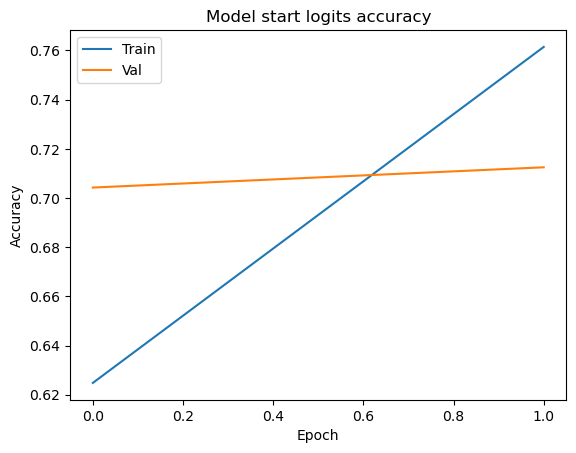

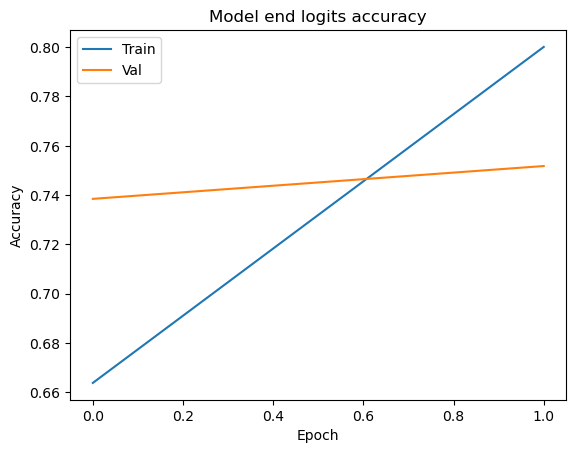

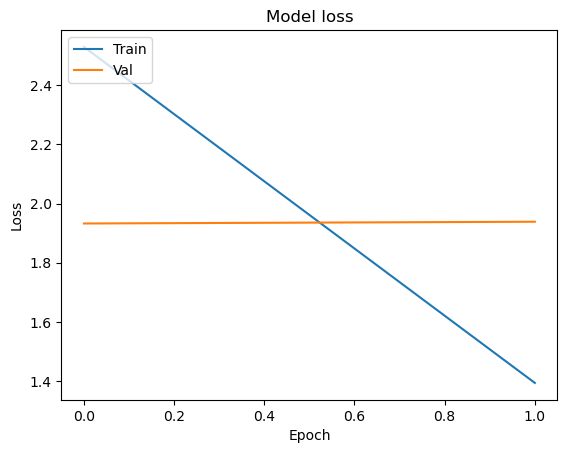

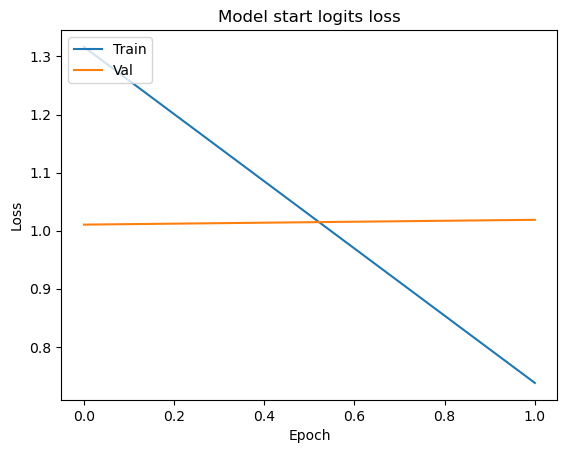

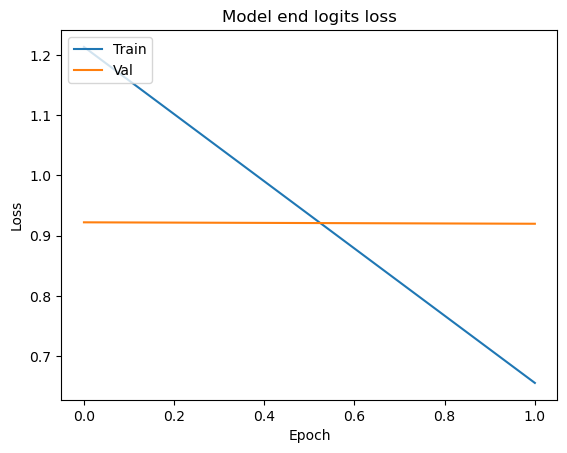

In [18]:
# Plot training figures
core_qa_utils.plot_and_save_fig_from_history(
    history,
    attributes=["start_logits_accuracy", "val_start_logits_accuracy"],
    title="Model start logits accuracy",
    y_label="Accuracy",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"{full_model_name}_start_accuracy.png",
)

core_qa_utils.plot_and_save_fig_from_history(
    history,
    attributes=["end_logits_accuracy", "val_end_logits_accuracy"],
    title="Model end logits accuracy",
    y_label="Accuracy",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"{full_model_name}_end_accuracy.png",
)

core_qa_utils.plot_and_save_fig_from_history(
    history,
    attributes=["loss", "val_loss"],
    title="Model loss",
    y_label="Loss",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"{full_model_name}_loss.png",
)

core_qa_utils.plot_and_save_fig_from_history(
    history,
    attributes=["start_logits_loss", "val_start_logits_loss"],
    title="Model start logits loss",
    y_label="Loss",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"{full_model_name}_start_loss.png",
)

core_qa_utils.plot_and_save_fig_from_history(
    history,
    attributes=["end_logits_loss", "val_end_logits_loss"],
    title="Model end logits loss",
    y_label="Loss",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"{full_model_name}_end_loss.png",
)

In [19]:
# Get best version of the model
best_model, best_epoch = core_qa_utils.get_best_model_from_checkpoints(
    model, history, model_name=full_model_name, remove_checkpoints=True
)

In [20]:
# Save best model's weights
extractive_qa_utils.save_model(best_model, model_name=full_model_name)

# Evaluation of the model on its test dataset

In [13]:
# Load best model
loaded_model = extractive_qa_utils.load_model(
    model_checkpoint, model_name=full_model_name
)
loaded_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

All PyTorch model weights were used when initializing TFBertForQuestionAnswering.

Some weights or buffers of the TF 2.0 model TFBertForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Get predictions from the best model
loaded_model_evaluation = loaded_model.evaluate(tf_test_dataset)

2748/3638 [=====================>........] - ETA: 39s - loss: 1.9565 - end_logits_loss: 0.9305 - start_logits_loss: 1.0260 - end_logits_accuracy: 0.7367 - start_logits_accuracy: 0.6984

KeyboardInterrupt: 

In [ ]:
loaded_model_preds = loaded_model.predict(tf_test_dataset)

In [ ]:
# Convert predictions to start and end position indices
start_preds = extractive_qa_utils.get_class_preds(
    predictions=loaded_model_preds, output_key="start_logits"
)
end_preds = extractive_qa_utils.get_class_preds(
    predictions=loaded_model_preds, output_key="end_logits"
)

In [ ]:
# Convert predictions to actual texts and mark samples as correctly predicted
model_predictions = tokenized_test_dataset.map(
    lambda row: extractive_qa_utils.extract_answer_tokens(row))

model_predictions = model_predictions.map(
    lambda row: extractive_qa_utils.decode_answer_tokens(row, tokenizer)
)

model_predictions = model_predictions.map(
    lambda row: extractive_qa_utils.mark_correct_predictions(row)
)

In [ ]:
# Calculate start positions classification metrics
(
    start_precision,
    start_recall,
    start_f1,
) = extractive_qa_utils.get_classification_evaluation_metrics(
    class_actual=tokenized_test_dataset["start_positions"],
    class_preds=start_preds,
    average="micro",
)

print(f"Start positions precision score: ", start_precision)
print(f"Start positions recall score: ", start_recall)
print(f"Start positions F1 score: ", start_f1)

In [ ]:
# Calculate end positions classification metrics
(
    end_precision,
    end_recall,
    end_f1,
) = extractive_qa_utils.get_classification_evaluation_metrics(
    class_actual=tokenized_test_dataset["end_positions"],
    class_preds=end_preds,
    average="micro",
)

print(f"End positions precision score: ", end_precision)
print(f"End positions recall score: ", end_recall)
print(f"End positions F1 score: ", end_f1)

In [ ]:
# Calculate exact match for the test set
(
    exact_match_original,
    exact_match_lowercase,
    exact_match_lowercase_no_punctuation,
) = extractive_qa_utils.calculate_pure_exact_match(
    actual=model_predictions["answer_text"],
    predicted=model_predictions["predicted_answer_text"],
)

print(f"Exact match for original dataset: ", exact_match_original["exact_match"])
print(f"Exact match case insensitive: ", exact_match_lowercase["exact_match"])
print(
    f"Exact match case insensitive and punctuation ignoring: ",
    exact_match_lowercase_no_punctuation["exact_match"],
)

In [ ]:
# Calculate squad exact match for the test set
squad_exact_match_results = extractive_qa_utils.calculate_squad_exact_match(
    model_predictions
)

print(f"SQuAD exact match: ", squad_exact_match_results["exact_match"])
print(f"SQuAD F1: ", squad_exact_match_results["f1"])

In [ ]:
# Save all relevant training and evaluation metrics to a json file.
evaluation_data = {
    "training": {
        "metrics": history.history,
        "attempted_epochs": train_epochs,
        "best_epoch": best_epoch,
        "training_time": time_measure_cb.total_training_time(),
        "gpu": core_qa_utils.get_gpu_name(),
    },
    "test_set": {
        "loss": loaded_model_evaluation[0],
        "end_logits_loss": loaded_model_evaluation[1],
        "start_logits_loss": loaded_model_evaluation[2],
        "end_logits_accuracy": loaded_model_evaluation[3],
        "start_logits_accuracy": loaded_model_evaluation[4],
        "start_positions": {
            "precision": start_precision,
            "recall": start_recall,
            "f1": start_f1,
        },
        "end_positions": {
            "precision": end_precision,
            "recall": end_recall,
            "f1": end_f1,
        },
        "exact_match": {
            "case_sensitive": exact_match_original["exact_match"],
            "case_insensitive": exact_match_lowercase["exact_match"],
            "case_insensitive_and_no_punctuation": exact_match_lowercase["exact_match"],
            "squad": squad_exact_match_results["exact_match"],
            "squad_f1": squad_exact_match_results["f1"],
        },
    },
}

core_qa_utils.save_dict_as_json(
    evaluation_data, dir_path=model_evaluation_dir, filename="evaluation_data.json"
)

In [ ]:
# Remove unnecessary columns
model_predictions = model_predictions.remove_columns(["input_ids",
                                  "token_type_ids",
                                  "attention_mask", "answer_tokens", "answer_start"])

In [ ]:
# Check if there exist any predictions where start position is greater than end positions
for prediction in model_predictions:
    if prediction['start_positions'] > prediction['end_positions']:
        print("Correct answer", prediction["answer_text"])
        print("Predicted answer: ", prediction["predicted_answer_text"])
        print("Start: ", prediction['start_positions'], " End: ", prediction["end_positions"])
        print("------------")

In [28]:
# Save test dataset evaluation
final_evaluation_df = model_predictions.to_pandas()
final_evaluation_df.to_csv(
    model_evaluation_dir / "test_set_evaluation.csv", index=True, index_label="index"
)

# Evaluation of model trained on SQuAD on COVID-19 dataset

Makes no sense due to the nature of the COVID-19 dataset which has very long contexts. This model however does not use stride technique and handles only shorter samples, making such evaluation obsolete.